# **THỰC HÀNH VỚI KMEANS**

In [97]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns


# **XỬ LÝ DỮ LIỆU**

In [98]:
train = pd.read_csv("/kaggle/input/week4work/Train.csv")
test =pd.read_csv("/kaggle/input/week4work/Test.csv")
train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


# **CHUẨN HÓA DỮ LIỆU**


In [100]:
# Kiểm tra dữ liệu null, NaN
print(train.isnull().sum())
print(train.isnull().values.any())

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64
True


In [101]:
mapping = {"Male": 0, "Female": 1, "No": 0, "Yes": 1, "Healthcare": 0, "Engineer": 1, "Lawyer": 2, "Artist": 3, "Executive": 4, "Doctor": 5, "Homemaker": 6, "Marketing": 7, "Low": 0, "Average": 1, "High": 2, "Cat_1": 0, "Cat_2": 1, "Cat_3": 2, "Cat_4": 3, "Cat_5": 4, "Cat_6": 5, "Cat_7": 6, "A": 0, "B": 1, "C": 2, "D": 3}

for col in ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1", "Segmentation"]:
    train[col] = train[col].map(mapping)

for col in ["Ever_Married", "Graduated", "Profession", "Work_Experience", "Family_Size", "Var_1"]:
    train[col] = train[col].fillna(round(train[col].median(), 0))


In [102]:
train.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [103]:
# Kiểm tra dữ liệu null, NaN
print(test.isnull().sum())
print(test.isnull().values.any())

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64
True


In [104]:
mapping = {
    "Gender": {"Male": 0, "Female": 1},
    "Ever_Married": {"No": 0, "Yes": 1},
    "Graduated": {"No": 0, "Yes": 1},
    "Profession": {
        "Healthcare": 0, "Engineer": 1, "Lawyer": 2, "Artist": 3,
        "Executive": 4, "Doctor": 5, "Homemaker": 6, "Marketing": 7
    },
    "Spending_Score": {"Low": 0, "Average": 1, "High": 2},
    "Var_1": {"Cat_1": 0, "Cat_2": 1, "Cat_3": 2, "Cat_4": 3, "Cat_5": 4, "Cat_6": 5, "Cat_7": 6}
}

# Apply mapping to columns
for col, col_mapping in mapping.items():
    test[col] = test[col].map(col_mapping)

# Fill missing values with median
columns_with_missing_values = ["Ever_Married", "Graduated", "Profession", "Work_Experience", "Family_Size", "Var_1"]
for col in columns_with_missing_values:
    test[col] = test[col].fillna(round(test[col].median(), 0))


In [105]:
test.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [106]:
X_train = train.drop(['ID', 'Segmentation'], axis = 1)
X_test = test.drop(['ID'], axis = 1)

# **Xây dựng thuật toán**


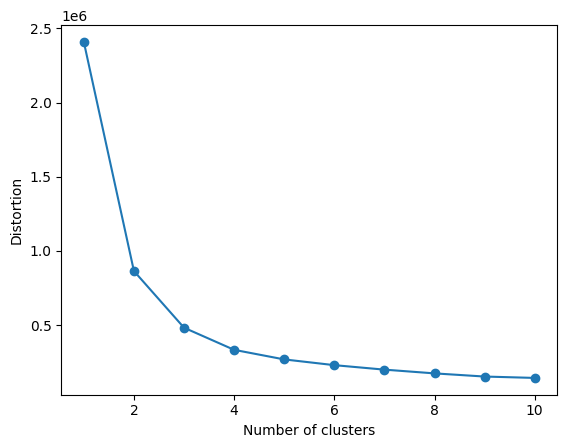

In [107]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
  km = KMeans(n_clusters=i, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=1)
  km.fit(X_train)
  distortions.append(km.inertia_)
# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [108]:
kmeans = KMeans(n_clusters = 3, random_state = 1, n_init='auto')
kmeans.fit(X_train)

KMeans(n_clusters=3, n_init='auto', random_state=1)

In [109]:
silhouette_score(X_train, kmeans.labels_, metric='euclidean')

0.4554179963348504

In [110]:
K = range(2, 10)
fits = []
score = []
i = 0
for k in K:
  i = i + 1
# train the model for current value of k on training data
  model = KMeans(n_clusters = k, random_state = 1, n_init='auto').fit(X_train)
# append the model to fits
  fits.append(model)
# Append the silhouette score to scores
  score.append(silhouette_score(X_train, model.labels_, metric='euclidean'))
  print(' k =' , k , ' score = ', score[-1])

 k = 2  score =  0.5365186196075322
 k = 3  score =  0.4554179963348504
 k = 4  score =  0.411855044722942
 k = 5  score =  0.3880829234984208
 k = 6  score =  0.37566641283379815
 k = 7  score =  0.35884642136436257
 k = 8  score =  0.3509879472828346
 k = 9  score =  0.3620069780888142


In [111]:
kmeans = KMeans(n_clusters = 3, random_state = 1, n_init='auto')
kmeans.fit(X_test)

KMeans(n_clusters=3, n_init='auto', random_state=1)

In [112]:
silhouette_score(X_test, kmeans.labels_, metric='euclidean')

0.4648347260959915

In [113]:
K = range(2, 10)
fits = []
score = []
i = 0
for k in K:
  i = i + 1
# train the model for current value of k on training data
  model = KMeans(n_clusters = k, random_state = 1, n_init='auto').fit(X_train)
# append the model to fits
  fits.append(model)
# Append the silhouette score to scores
  score.append(silhouette_score(X_train, model.labels_, metric='euclidean'))
  print(' k =' , k , ' score = ', score[-1])

 k = 2  score =  0.5365186196075322
 k = 3  score =  0.4554179963348504
 k = 4  score =  0.411855044722942
 k = 5  score =  0.3880829234984208
 k = 6  score =  0.37566641283379815
 k = 7  score =  0.35884642136436257
 k = 8  score =  0.3509879472828346
 k = 9  score =  0.3620069780888142


# **Xác định số lượng cụm**

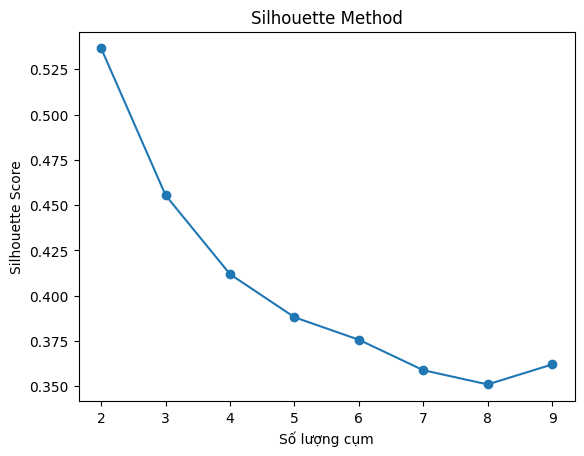

In [114]:
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Số lượng cụm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

# **KẾT LUẬN**

# - Khi chúng ta thực hiện phân cụm với k = 2, Silhouette Score đạt ~ 0.5365, cho thấy sự tách biệt tốt giữa hai cụm. Tuy nhiên, lựa chọn k = 2 có thể coi là quá đơn giản, bởi vì nó không tận dụng hết thông tin phân tán trong dữ liệu và chỉ tạo hai cụm.
# - Khi chúng ta tăng k lên 3, Silhouette Score giảm xuống ~0.4554, nhưng vẫn ở mức tương đối cao. Việc chọn k = 3 có thể là lựa chọn tốt hơn để chia dữ liệu thành ba cụm. Với k = 3, có khả năng phân chia rõ ràng hơn các đặc trưng và biểu thị một phân cụm thứ ba, mà có thể là quan trọng trong phân tích dữ liệu.

# ==> Dựa vào Silhouette Score, nên chọn k = 3 có vẻ hợp lý trong trường hợp này. Điều này cho phép chúng ta tận dụng sự phân tán và đa dạng trong dữ liệu hơn, giúp chia thành ba cụm thay vì chỉ hai, và có thể cung cấp thông tin giá trị hơn cho phân tích của chúng ta.